# NYPD Shooting Incident Data

In [1]:
import pandas as pd
import numpy as np
import time
import datetime as dt
import folium
from IPython.display import HTML

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
historic_orig = pd.read_csv('data/NYPD_Shooting_Incident_Data__Historic_.csv')
ytd_orig = pd.read_csv('data/NYPD_Shooting_Incident_Data__Year_To_Date_.csv')

In [3]:
historic_orig.columns

Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'PRECINCT',
       'JURISDICTION_CODE', 'LOCATION_DESC', 'STATISTICAL_MURDER_FLAG',
       'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE', 'VIC_AGE_GROUP', 'VIC_SEX',
       'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude'],
      dtype='object')

In [4]:
def clean(df):
    df['DATESTAMP'] = pd.to_datetime(df.OCCUR_DATE + ' ' + df.OCCUR_TIME, errors='coerce')
    return df.drop(['OCCUR_DATE', 'OCCUR_TIME', 'X_COORD_CD', 'Y_COORD_CD'], axis=1)

historic_clean = clean(historic_orig)
ytd_clean = clean(ytd_orig)

In [5]:
main = pd.concat([historic_clean, ytd_clean])

In [6]:
main.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6848 entries, 0 to 440
Data columns (total 15 columns):
INCIDENT_KEY               6848 non-null int64
BORO                       6848 non-null object
PRECINCT                   6848 non-null int64
JURISDICTION_CODE          6848 non-null int64
LOCATION_DESC              2344 non-null object
STATISTICAL_MURDER_FLAG    6848 non-null bool
PERP_AGE_GROUP             3635 non-null object
PERP_SEX                   3635 non-null object
PERP_RACE                  3635 non-null object
VIC_AGE_GROUP              6848 non-null object
VIC_SEX                    6848 non-null object
VIC_RACE                   6848 non-null object
Latitude                   6848 non-null float64
Longitude                  6848 non-null float64
DATESTAMP                  6848 non-null datetime64[ns]
dtypes: bool(1), datetime64[ns](1), float64(2), int64(3), object(8)
memory usage: 809.2+ KB


In [7]:
main.sample(1)

,INCIDENT_KEY,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,Latitude,Longitude,DATESTAMP
1939,151770860,BRONX,40,0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,40.812291,-73.904468,2016-04-01 23:45:00


# Distribution Plots

In [8]:
def plot_dist(df, cols, title, fname=str(time.time()), size=(25, 15)):
    def plot(col, ax):
        df[col][df[col].notnull()].value_counts().plot('bar', ax=ax)
        ax.set_title("{}".format(col), fontsize= 18)
        return ax
    f, ax = plt.subplots(1, len(cols), figsize=size)
    for i in range(len(cols)):
        plot(cols[i], ax[i])
    __ = plt.suptitle(title, fontsize= 25)
    f.savefig('figs/%s.png'%fname)

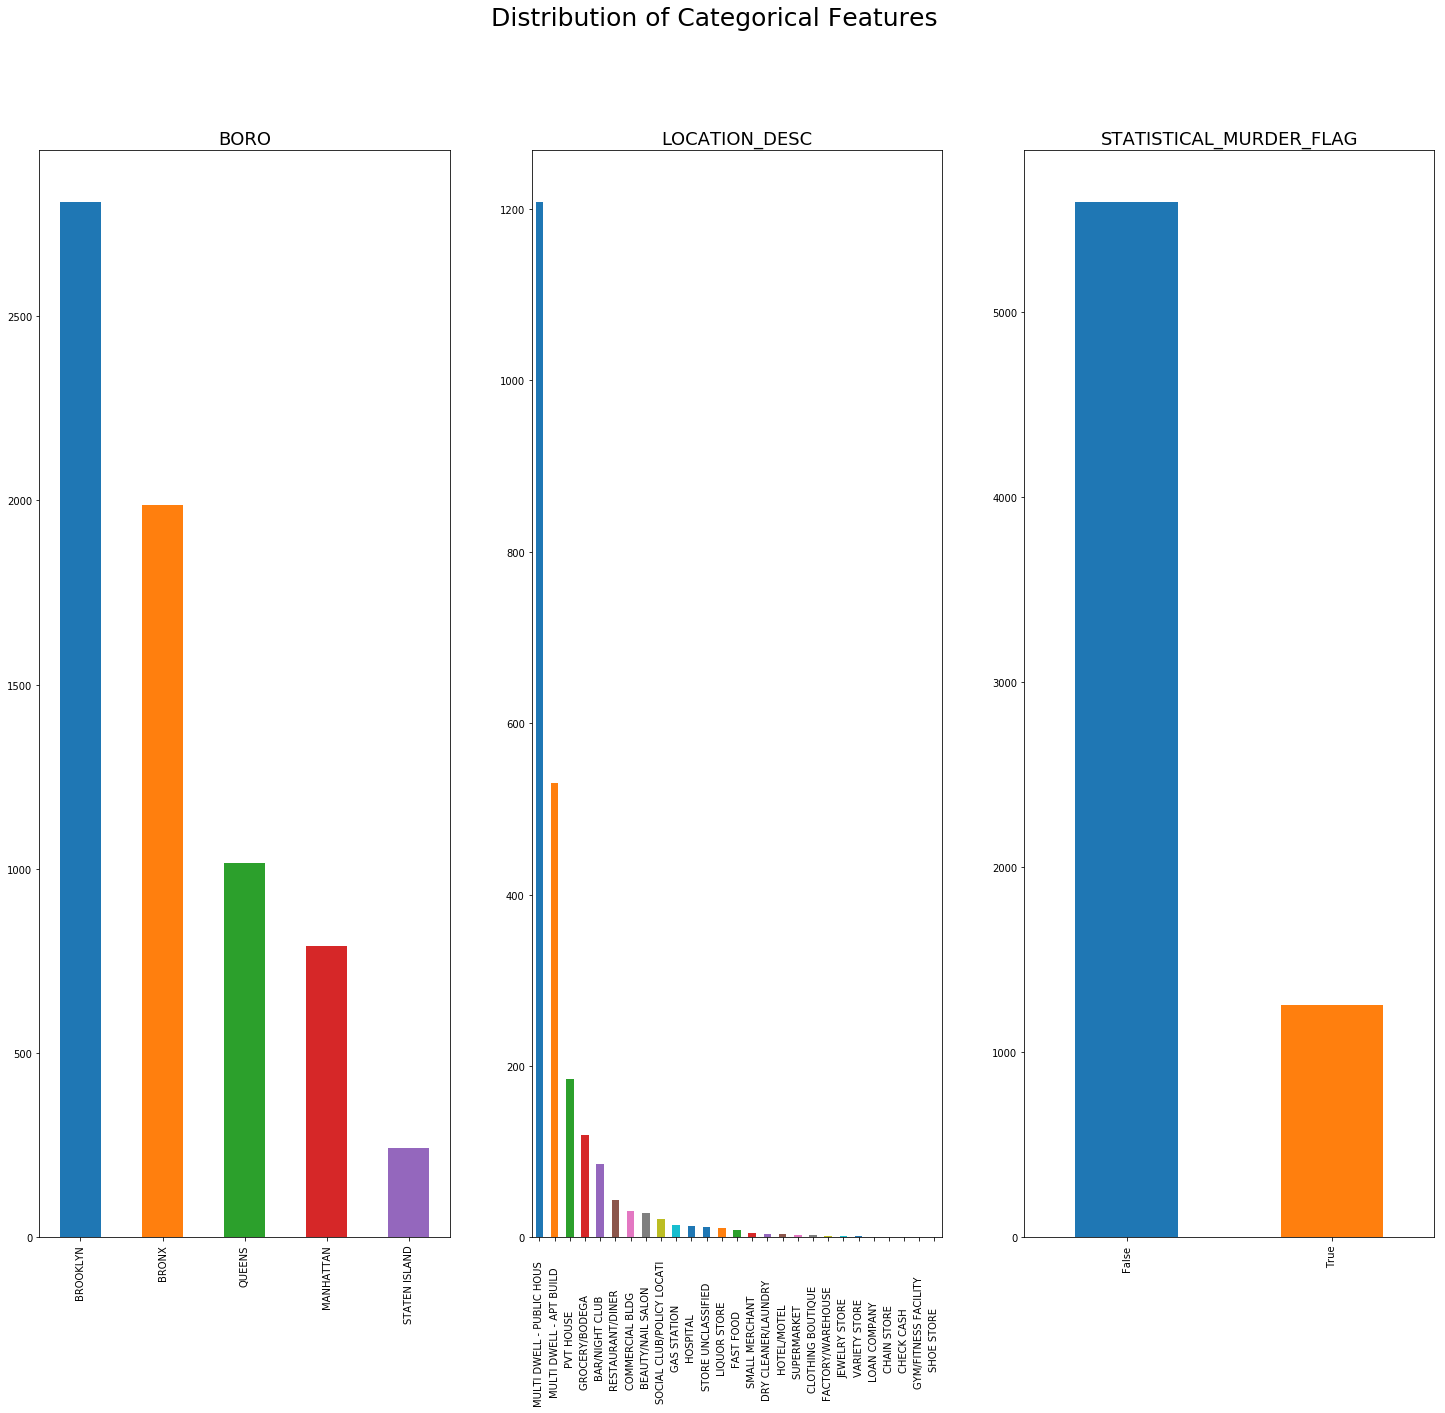

In [9]:
plot_dist(main, ['BORO', 'LOCATION_DESC', 'STATISTICAL_MURDER_FLAG'], 'Distribution of Categorical Features', fname='count_all', size=(25, 20))

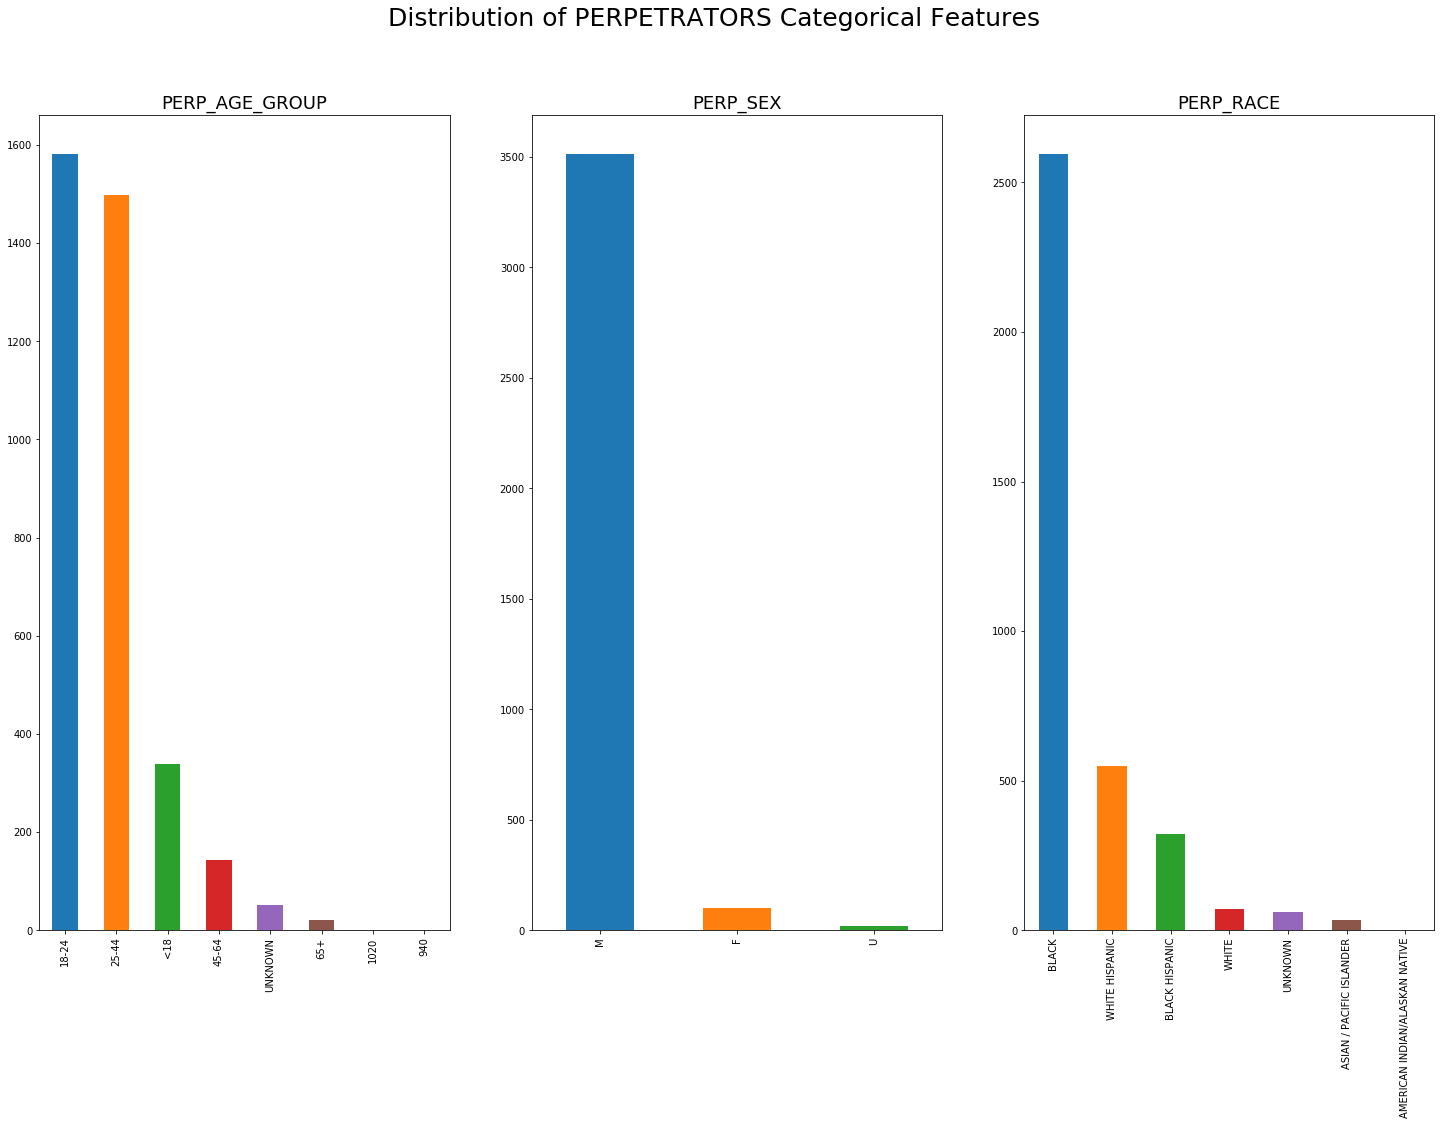

In [10]:
plot_dist(main, ['PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE'], 'Distribution of PERPETRATORS Categorical Features', fname='perp')

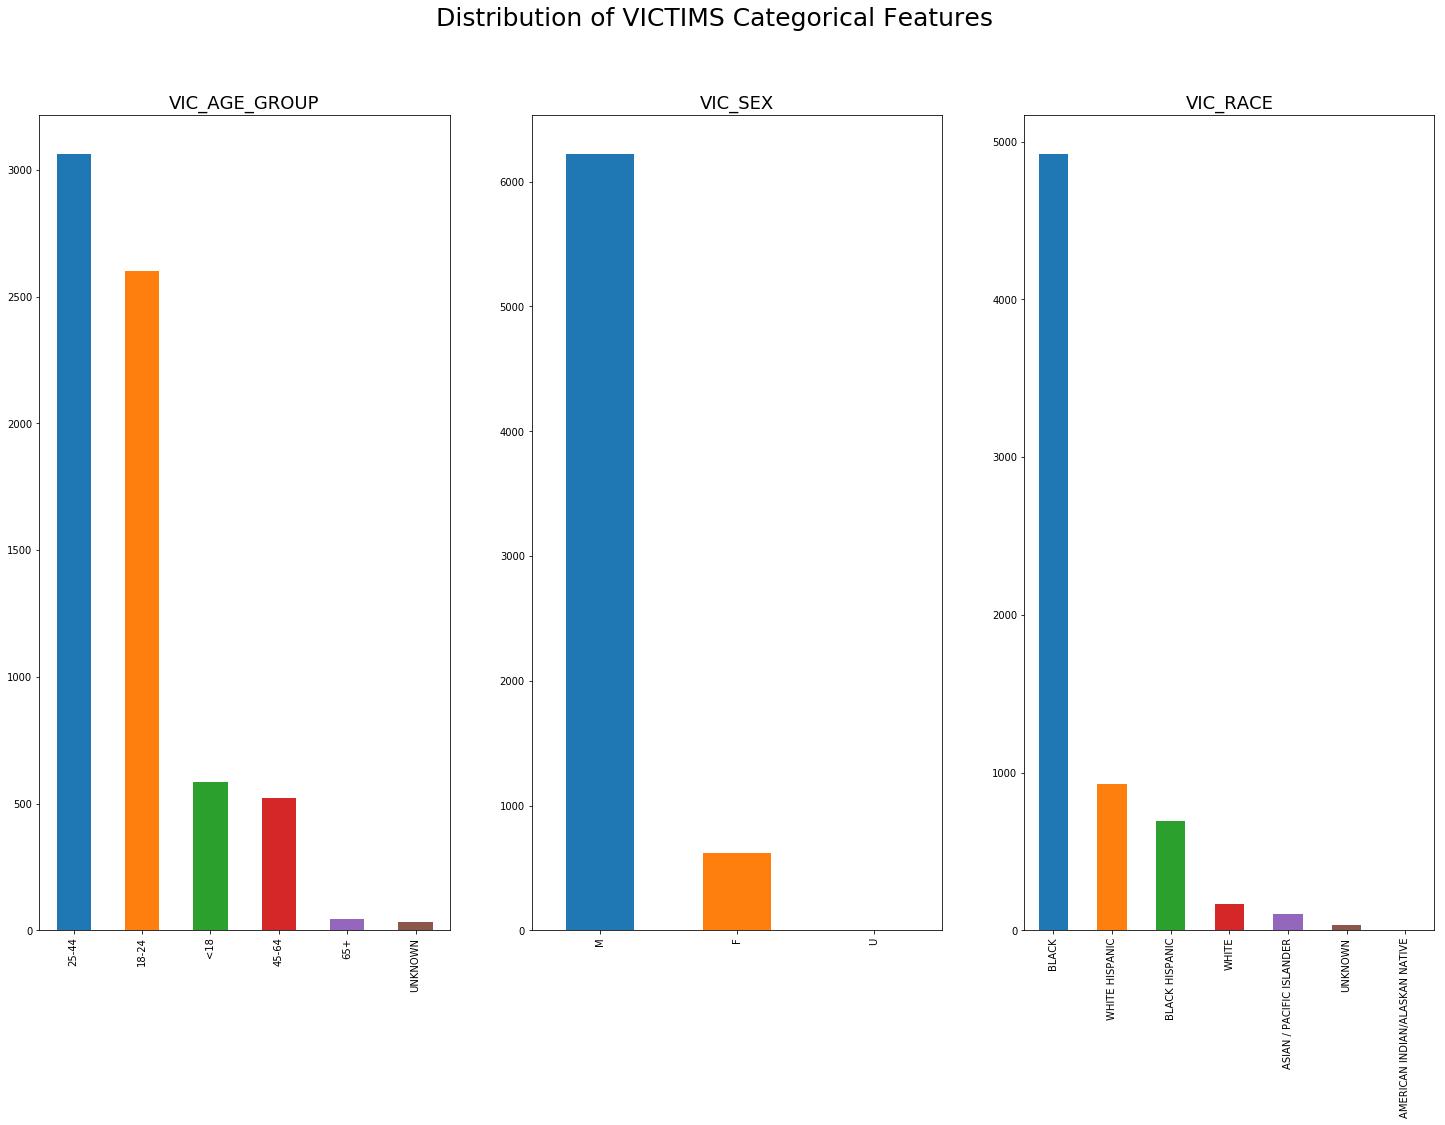

In [11]:
plot_dist(main, ['VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE'], 'Distribution of VICTIMS Categorical Features', fname='vic')

# Missing Data Analysis

- No missing value for VIC_RACE

In [12]:
race = main.loc[:, ['PERP_RACE', 'VIC_RACE', 'STATISTICAL_MURDER_FLAG']]

In [13]:
len(race.loc[race['VIC_RACE'].isnull(), 'PERP_RACE'])

0

In [14]:
race.loc[race['PERP_RACE'].isnull(), :].reset_index(drop=False).groupby(['VIC_RACE', 'STATISTICAL_MURDER_FLAG'])['index'].count()

VIC_RACE                        STATISTICAL_MURDER_FLAG
AMERICAN INDIAN/ALASKAN NATIVE  False                         1
ASIAN / PACIFIC ISLANDER        False                        23
                                True                          4
BLACK                           False                      2135
                                True                        360
BLACK HISPANIC                  False                       270
                                True                         25
UNKNOWN                         False                         9
WHITE                           False                        40
                                True                          8
WHITE HISPANIC                  False                       304
                                True                         34
Name: index, dtype: int64

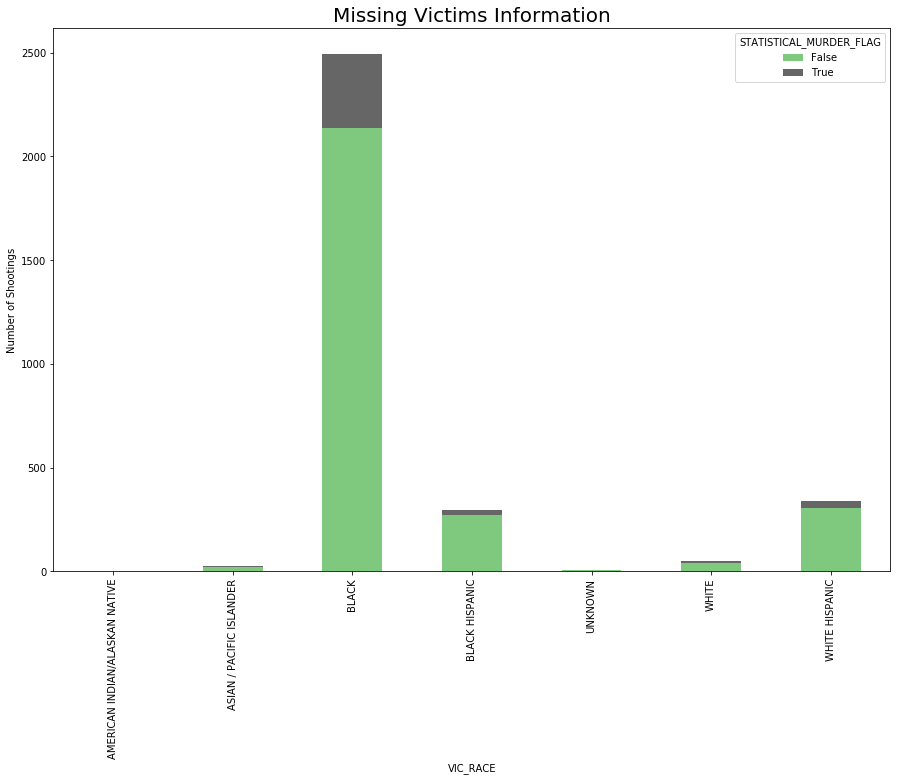

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
race.loc[race['PERP_RACE'].isnull(), :].reset_index(drop=False).pivot_table(index='VIC_RACE', columns='STATISTICAL_MURDER_FLAG', 
                                                                            values='index', aggfunc='count').plot(kind='bar', 
                                                                                                                  stacked=True, cmap='Accent', ax=ax)
ax.set_ylabel('Number of Shootings')
ax.set_title('Missing Victims Information', fontsize= 20)
fig.savefig('figs/%s.png'%'perp_missing')

In [16]:
len(race.loc[(race['PERP_RACE'].notnull()) & (race['VIC_RACE'] != 'UNKNOWN')])

3609

# Time Trends

In [17]:
# EDA: how many types/value_counts of BORO, PRECINT, LOCATION

# Missing Data Analysis

# Time trends plots
# Groupby month/year, count #shootings
# Groupby month/year, count #race (perp/victim)
# Groupby month/year, count #age_group (perp/victim)
# Groupby month/year, count #sex (perp/victim)
# Groupby month/year, count #age_group (perp/victim)

# Visualization flag for police shootings, flag for Statistical Murder Flag
# Murder/non-murder, male, female

In [18]:
main['Month-Year'] = main.DATESTAMP.dt.to_period('M')

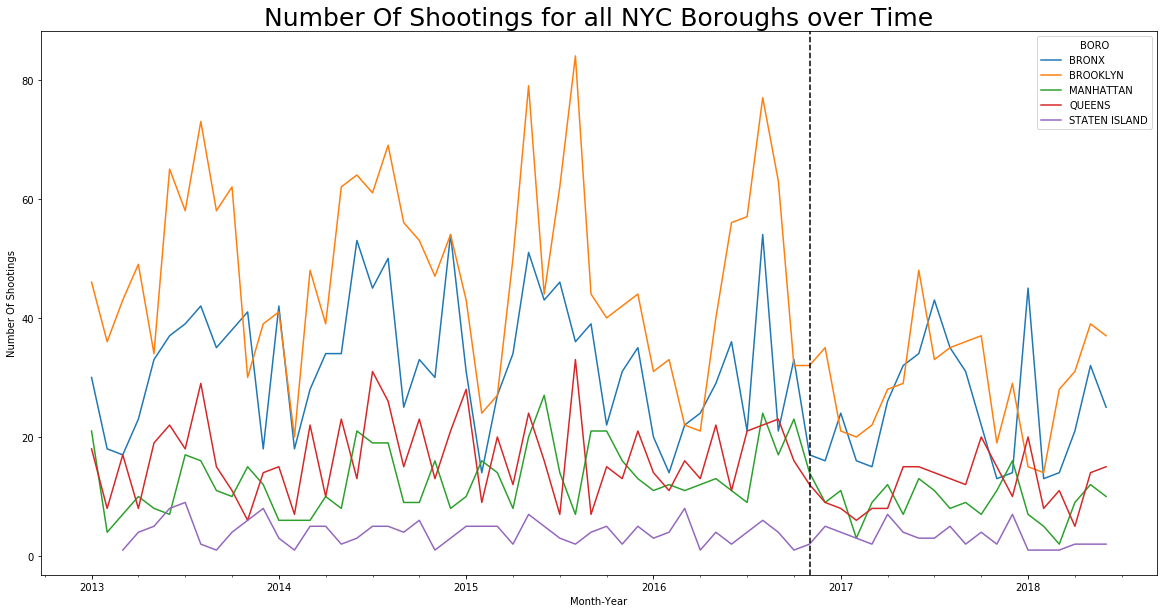

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
main.pivot_table(index='Month-Year', columns='BORO', values='INCIDENT_KEY', aggfunc='count').plot(figsize=(20, 10), ax=ax)
ax.axvline(x='2016-11', color='black', linestyle='--', )
ax.set_ylabel('Number Of Shootings')
ax.set_title('Number Of Shootings for all NYC Boroughs over Time', fontsize=25)
fig.savefig('figs/boro_time.png')

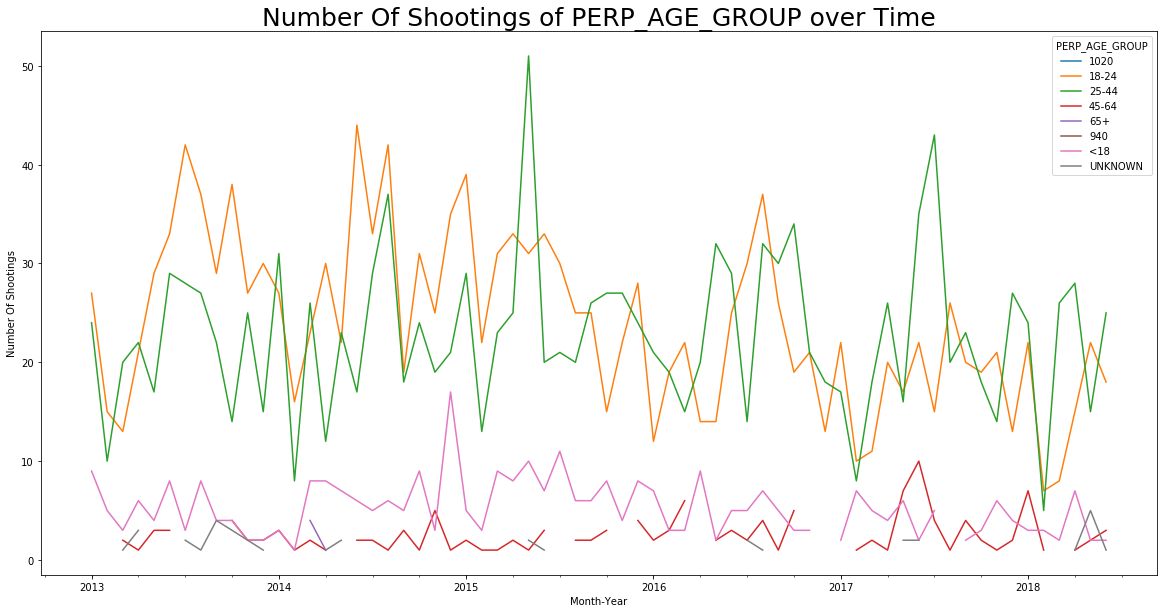

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
main.pivot_table(index='Month-Year', columns='PERP_AGE_GROUP', values='INCIDENT_KEY', aggfunc='count').plot(figsize=(20, 10), ax=ax)
ax.set_ylabel('Number Of Shootings')
ax.set_title('Number Of Shootings of PERP_AGE_GROUP over Time', fontsize=25)
fig.savefig('figs/perp_age_time.png')

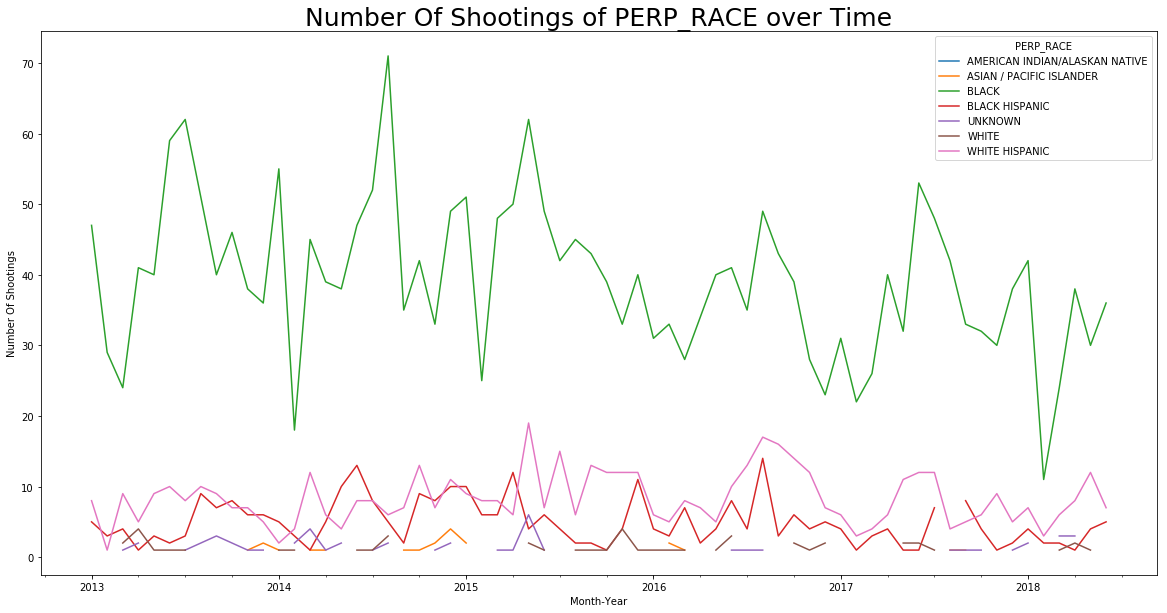

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
main.pivot_table(index='Month-Year', columns='PERP_RACE', values='INCIDENT_KEY', aggfunc='count').plot(figsize=(20, 10), ax=ax)
ax.set_ylabel('Number Of Shootings')
ax.set_title('Number Of Shootings of PERP_RACE over Time', fontsize=25)
fig.savefig('figs/perp_race_time.png')

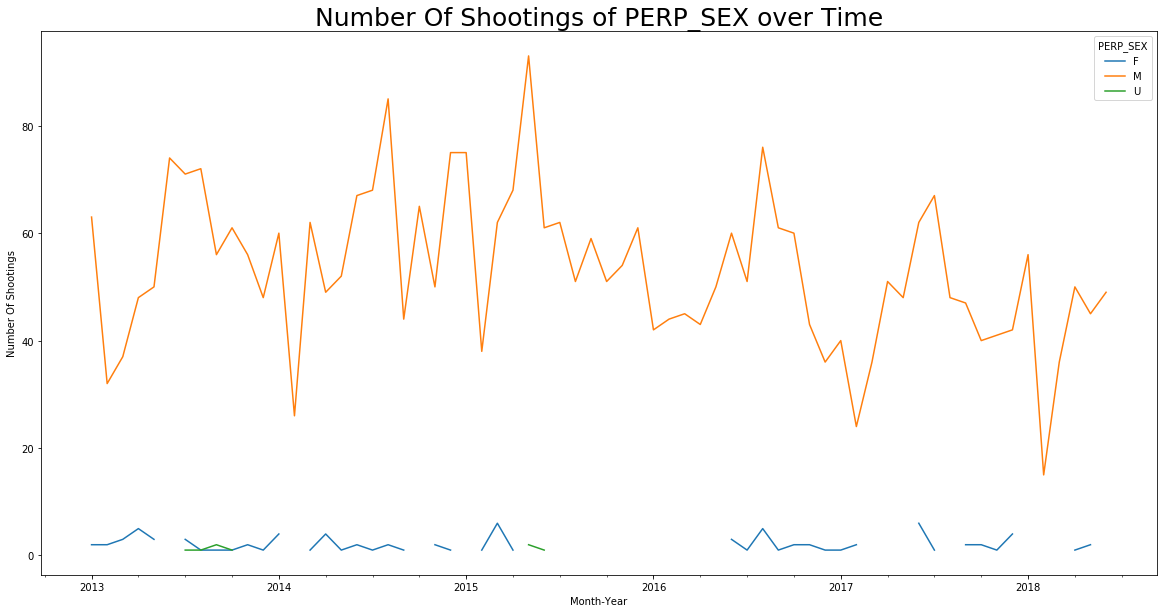

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
main.pivot_table(index='Month-Year', columns='PERP_SEX', values='INCIDENT_KEY', aggfunc='count').plot(figsize=(20, 10), ax=ax)
ax.set_ylabel('Number Of Shootings')
ax.set_title('Number Of Shootings of PERP_SEX over Time', fontsize=25)
fig.savefig('figs/perp_sex_time.png')

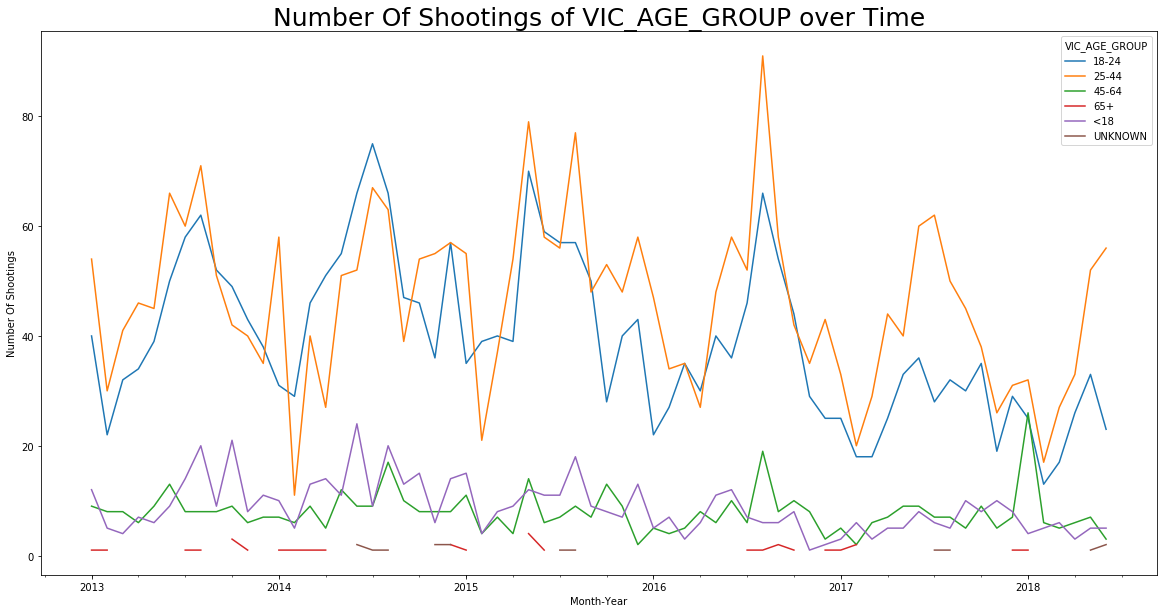

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
main.pivot_table(index='Month-Year', columns='VIC_AGE_GROUP', values='INCIDENT_KEY', aggfunc='count').plot(figsize=(20, 10), ax=ax)
ax.set_ylabel('Number Of Shootings')
ax.set_title('Number Of Shootings of VIC_AGE_GROUP over Time', fontsize=25)
fig.savefig('figs/vic_age_time.png')

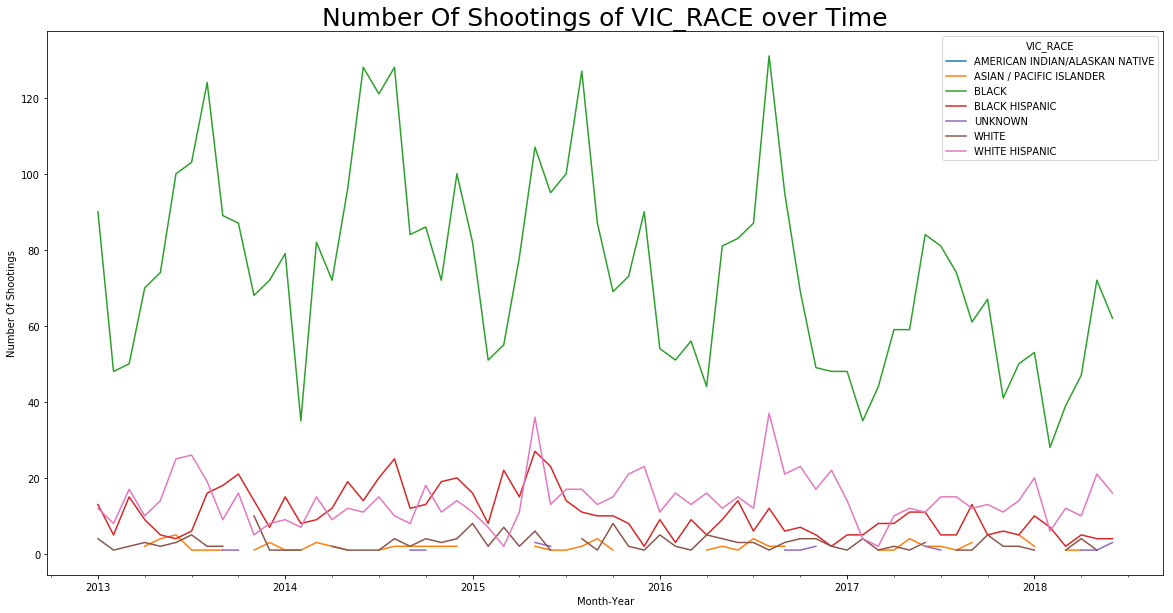

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
main.pivot_table(index='Month-Year', columns='VIC_RACE', values='INCIDENT_KEY', aggfunc='count').plot(figsize=(20, 10), ax=ax)
ax.set_ylabel('Number Of Shootings')
ax.set_title('Number Of Shootings of VIC_RACE over Time', fontsize=25)
fig.savefig('figs/vic_race_time.png')

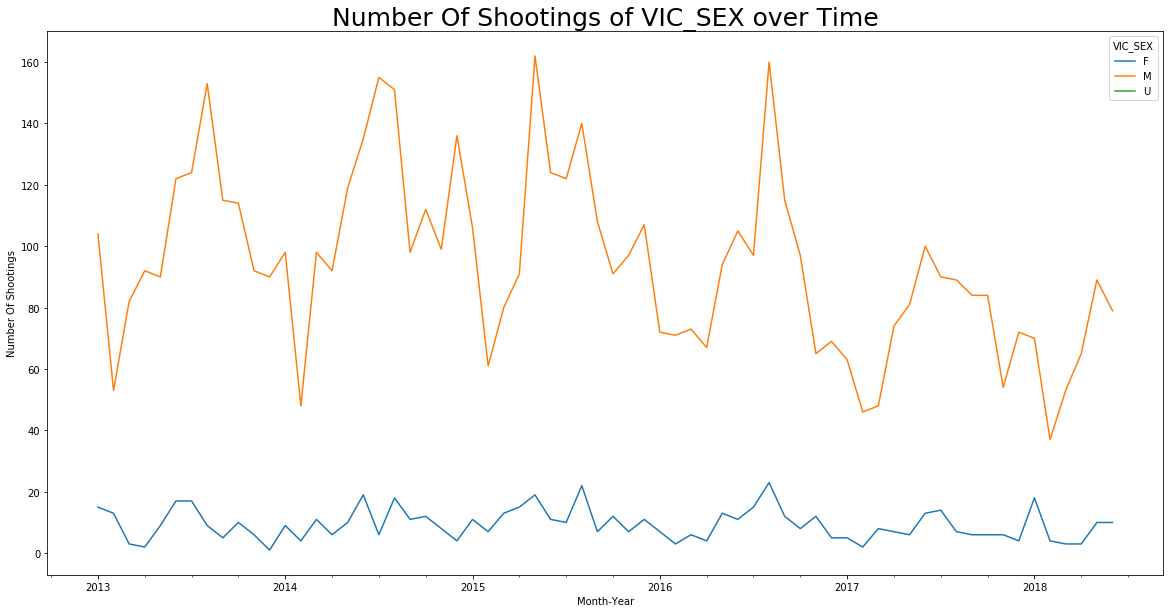

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
main.pivot_table(index='Month-Year', columns='VIC_SEX', values='INCIDENT_KEY', aggfunc='count').plot(figsize=(20, 10), ax=ax)
ax.set_ylabel('Number Of Shootings')
ax.set_title('Number Of Shootings of VIC_SEX over Time', fontsize=25)
fig.savefig('figs/vic_sex_time.png')

In [26]:
def create_folium_map(df):
    NYC_COORDINATES = (40.730610, -73.935242)
    m = folium.Map(location=NYC_COORDINATES, zoom_start=10)
    for i, row in df.iterrows():
        icon_color = 'blue'
        if row.STATISTICAL_MURDER_FLAG: icon_color = 'red'
        folium.Marker(location=[row.Latitude, row.Longitude], 
                      popup='Time: %s. Location: %s' %(str(row.DATESTAMP), row.LOCATION_DESC), 
                      icon=folium.Icon(color=icon_color)).add_to(m)
    return m

In [27]:
viz14 = create_folium_map(main[main.DATESTAMP.dt.year==2014])
viz14.save('viz14.html')

In [28]:
viz18 = create_folium_map(main[main.DATESTAMP.dt.year==2018])
viz18.save('viz18.html')

In [33]:
viz18